## Circuit classification
Notebook consists of 2 stages:
1. Generate examples of random graphs and save to file
2. Generate features from the graphs and save features to a file

In [1]:
%reload_ext autoreload
%autoreload 2

from analytic import *
from spice_net import *
import networkx as nx
import numpy as np
import tqdm
from sklearn.neighbors import KDTree
from circuit_classification_utils.classifiers import *

### Idea 1: Train standard fully connected neural network directly on circuit matrices

#### Preprocess dataset
Procedure:
1. Flatten the data so that we can use an MLP
2. Weight datapoints to avoid imbalance as follows: weight each point by 
$$w_i = \sqrt{\frac{\text{\# of points in total}}{\text{\# of neighbors within distance} r \text{ to point }i}}$$

In [88]:
data = np.load('data/slope_intercept.npz')
X = data['X']
y = data['y']

In [89]:
# Flatten X so that the MLP can use it as input
X = X.reshape((X.shape[0], -1))

In [90]:
# Create weights for each sample
r = 0.25
kd = KDTree(y)

all_pairs = kd.query_radius(y, r=r, count_only=True) + 1 # Add 1 to avoid division by zero
weights = np.sqrt(X.shape[0] / all_pairs)
print(weights.min(), weights.max())

1.2532745410970598 129.09944487358058


In [91]:
dataset = Circuit_Dataset(X, y, weights)

In [92]:
# Create training and validation sets
train_data, val_data = torch.utils.data.random_split(dataset, [0.8, 0.2])

In [93]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu") # Macbook CPU is really fast
print("Using device", device)

epochs = 10
batch_size = 128
learning_rate = 1e-2

weighted = False

n_layers = 4
hidden_dim = 50

model = MLP(n_layers, hidden_dim, 100, 2).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=1e-4)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

log_data = dict(
    train_loss = [],
    val_loss = [],
)

model.train() # Put model in training mode
for epoch in tqdm.trange(epochs):
    training_losses = []
    for x, y, w in train_dataloader:
        x, y, w = x.to(device), y.to(device), w.to(device)[:, None]
        optimizer.zero_grad() # Remove the gradients from the previous step
        pred = model(x)
        if weighted:
            loss = criterion(w*pred, w*y) # Option 1: weight data points by frequency
        else:
            loss = criterion(pred, y) # Option 2: do not weight data
        loss.backward()
        optimizer.step()
        training_losses.append(loss.item())
        
    scheduler.step()
    log_data['train_loss'].append(np.mean(training_losses))
        
    with torch.no_grad():
        model.eval() # Put model in eval mode
        val_losses = []
        for x, y, w in val_dataloader:
            x, y, w = x.to(device), y.to(device), w.to(device)[:, None]
            pred = model(x)
            if weighted:
                loss = criterion(w*pred, w*y) # Option 1: weight data points by frequency
            else:
                loss = criterion(pred, y) # Option 2: do not weight data
            val_losses.append(loss.item())
        model.train() # Put model back in train mode

    log_data['val_loss'].append(np.mean(val_losses))


    print("Finished Epoch", epoch + 1)
    print("Training loss:", log_data['train_loss'][-1], "Val loss:", log_data['val_loss'][-1])

Using device cpu


 10%|█         | 1/10 [00:01<00:14,  1.65s/it]

Finished Epoch 1
Training loss: 0.10948166627282152 Val loss: 0.04645782900101776


 20%|██        | 2/10 [00:02<00:11,  1.39s/it]

Finished Epoch 2
Training loss: 0.042872926256003474 Val loss: 0.042147543729294704


 30%|███       | 3/10 [00:05<00:14,  2.05s/it]

Finished Epoch 3
Training loss: 0.041027223780608406 Val loss: 0.04125234791183773


 40%|████      | 4/10 [00:07<00:10,  1.82s/it]

Finished Epoch 4
Training loss: 0.040558011208574614 Val loss: 0.040992043582321724


 50%|█████     | 5/10 [00:08<00:08,  1.66s/it]

Finished Epoch 5
Training loss: 0.04033821712310512 Val loss: 0.04081922953453245


 60%|██████    | 6/10 [00:09<00:06,  1.56s/it]

Finished Epoch 6
Training loss: 0.04024528705488188 Val loss: 0.041056918381135676


 70%|███████   | 7/10 [00:11<00:04,  1.57s/it]

Finished Epoch 7
Training loss: 0.04020950781961028 Val loss: 0.04061514707400075


 80%|████████  | 8/10 [00:13<00:03,  1.64s/it]

Finished Epoch 8
Training loss: 0.04015952229690247 Val loss: 0.040579284670986704


 90%|█████████ | 9/10 [00:14<00:01,  1.58s/it]

Finished Epoch 9
Training loss: 0.04015177071761018 Val loss: 0.040690493522376955


100%|██████████| 10/10 [00:16<00:00,  1.63s/it]

Finished Epoch 10
Training loss: 0.04012783768530281 Val loss: 0.04073651670183562


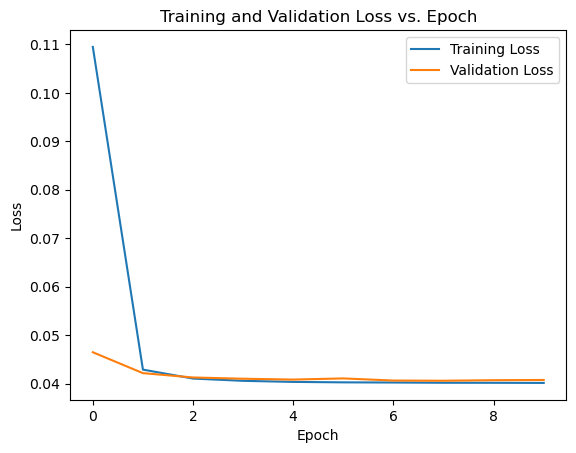

In [94]:
plt.plot(log_data['train_loss'], label='Training Loss')
plt.plot(log_data['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Epoch')
plt.show()

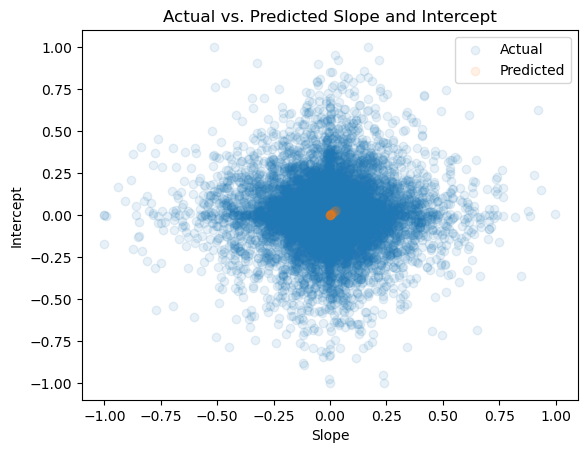

In [95]:
plt.scatter(*np.array(list(val_data[:][1].numpy())).T, label='Actual', alpha=.1)
plt.scatter(*np.transpose(pred), label='Predicted', alpha=.1)
plt.legend()
plt.xlabel('Slope')
plt.ylabel('Intercept')
plt.title('Actual vs. Predicted Slope and Intercept')
plt.show()

### Idea 2: Train a fully connected neural network on manually selected features

#### Preprocess dataset
Procedure:
1. Use pre-selected features defined in `gen_data.ipynb`

In [99]:
data = np.load('data/slope_intercept_hand_features.npz')
X = data['X']
y = data['y']

In [100]:
n_pts, n_features = X.shape

In [101]:
# Create weights for each sample
r = 0.25
kd = KDTree(y)

all_pairs = kd.query_radius(y, r=r, count_only=True) + 1 # Add 1 to avoid division by zero
weights = np.sqrt(X.shape[0] / all_pairs)
print(weights.min(), weights.max())

1.2524382717269813 158.14234094637652


In [102]:
dataset = Circuit_Dataset(X, y, weights)

In [103]:
# Create training and validation sets
train_data, val_data = torch.utils.data.random_split(dataset, [0.8, 0.2])

In [110]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu") # Macbook CPU is really fast
print("Using device", device)

epochs = 10
batch_size = 128
learning_rate = 1e-2

weighted = False

n_layers = 4
hidden_dim = 50

model = MLP(n_layers, hidden_dim, n_features, 2).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=1e-4)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

log_data = dict(
    train_loss = [],
    val_loss = [],
)

model.train() # Put model in training mode
for epoch in tqdm.trange(epochs):
    training_losses = []
    for x, y, w in train_dataloader:
        x, y, w = x.to(device), y.to(device), w.to(device)[:, None]
        optimizer.zero_grad() # Remove the gradients from the previous step
        pred = model(x)
        if weighted:
            loss = criterion(w*pred, w*y) # Option 1: weight data points by frequency
        else:
            loss = criterion(pred, y) # Option 2: do not weight data
        loss.backward()
        optimizer.step()
        training_losses.append(loss.item())
        
    scheduler.step()
    log_data['train_loss'].append(np.mean(training_losses))
        
    with torch.no_grad():
        model.eval() # Put model in eval mode
        val_losses = []
        for x, y, w in val_dataloader:
            x, y, w = x.to(device), y.to(device), w.to(device)[:, None]
            pred = model(x)
            if weighted:
                loss = criterion(w*pred, w*y) # Option 1: weight data points by frequency
            else:
                loss = criterion(pred, y) # Option 2: do not weight data
            val_losses.append(loss.item())
        model.train() # Put model back in train mode

    log_data['val_loss'].append(np.mean(val_losses))


    print("Finished Epoch", epoch + 1)
    print("Training loss:", log_data['train_loss'][-1], "Val loss:", log_data['val_loss'][-1])

Using device cpu


 10%|█         | 1/10 [00:01<00:09,  1.09s/it]

Finished Epoch 1
Training loss: 0.08699631413069968 Val loss: 0.04291669894717162


 20%|██        | 2/10 [00:02<00:08,  1.02s/it]

Finished Epoch 2
Training loss: 0.042126379924984025 Val loss: 0.040627334219745445


 30%|███       | 3/10 [00:03<00:07,  1.02s/it]

Finished Epoch 3
Training loss: 0.04125425923532381 Val loss: 0.04012217323142517


 40%|████      | 4/10 [00:04<00:06,  1.07s/it]

Finished Epoch 4
Training loss: 0.04101402119706614 Val loss: 0.04009400534478924


 50%|█████     | 5/10 [00:05<00:05,  1.03s/it]

Finished Epoch 5
Training loss: 0.04092077971599734 Val loss: 0.040055823759942114


 60%|██████    | 6/10 [00:06<00:04,  1.01s/it]

Finished Epoch 6
Training loss: 0.04087159966532224 Val loss: 0.04010657610112353


 70%|███████   | 7/10 [00:07<00:02,  1.04it/s]

Finished Epoch 7
Training loss: 0.040852371442575044 Val loss: 0.040188052561841436


 80%|████████  | 8/10 [00:08<00:01,  1.01it/s]

Finished Epoch 8
Training loss: 0.040839930020344146 Val loss: 0.03987581245129621


 90%|█████████ | 9/10 [00:09<00:00,  1.01it/s]

Finished Epoch 9
Training loss: 0.04083590597485582 Val loss: 0.04017975919325895


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]

Finished Epoch 10
Training loss: 0.040829468423280474 Val loss: 0.03989999517326868


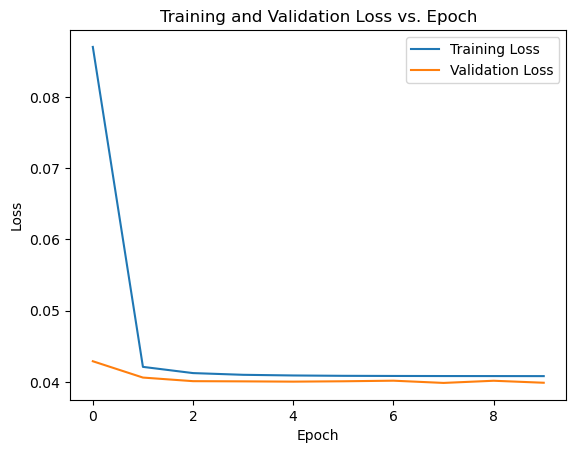

In [111]:
plt.plot(log_data['train_loss'], label='Training Loss')
plt.plot(log_data['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Epoch')
plt.show()

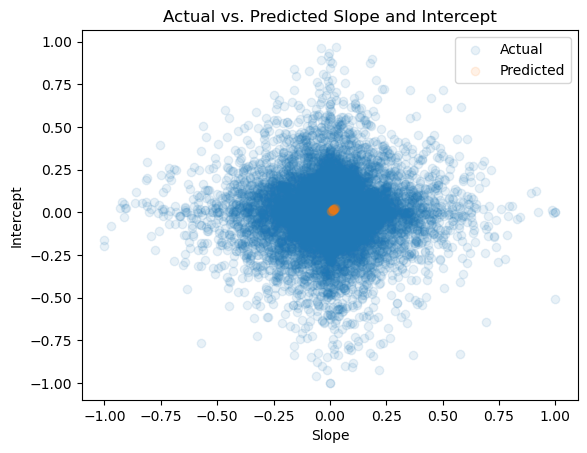

In [112]:
plt.scatter(*np.array(list(val_data[:][1].numpy())).T, label='Actual', alpha=.1)
plt.scatter(*np.transpose(pred), label='Predicted', alpha=.1)
plt.legend()
plt.xlabel('Slope')
plt.ylabel('Intercept')
plt.title('Actual vs. Predicted Slope and Intercept')
plt.show()